## 🚀 Python Lab: Tesla stock price prediction using LSTM networks (TensorFlow/Keras Version)
> [Principles of ML course](https://github.com/mnarimani/PML_Spring2025_SUT) - Spring 2025 - Sharif <br>
> Lab sessions - Session 9 - May 25, 2025 <br>
> Author: M Narimani <br>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mnarimani/PML_Spring2025_SUT/blob/main/Week09/03_LSTM_TeslaStock_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mnarimani/PML_Spring2025_SUT/blob/main/Week09/03_LSTM_TeslaStock_Keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## 🛠️ Setup: Importing Libraries
> **TODO:** Install the required packages/libs
> - `pip install pandas_datareader` <br>
> - `pip install yfinance`
<pip install yfinance>
<pip install fix_yahoo_finance>

In [4]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print("GPU name:", gpus)
print("Num GPUs Available:", len(gpus))

## 1️⃣ Load Historical Data

In [6]:
# Override pandas_datareader with yfinance
# yf.pdr_override()

# Define date ranges
train_start = datetime.datetime(2019, 1, 1)
train_end = datetime.datetime(2023, 12, 30)
val_start = datetime.datetime(2024, 1, 1)
val_end = datetime.date.today()

# Fetch training and validation data using yfinance directly
df = yf.download("TSLA", start=train_start, end=train_end, auto_adjust=True)
val_df = yf.download("TSLA", start=val_start, end=val_end, auto_adjust=True)

# Sort by date and reset index
df = df.sort_index().reset_index().set_index("Date")
val_df = val_df.sort_index().reset_index().set_index("Date")

# Display last few rows of training data
df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2023-12-22,252.539993,258.220001,251.369995,256.760010,93249800
2023-12-26,256.609985,257.970001,252.910004,254.490005,86892400
2023-12-27,261.440002,263.339996,257.519989,258.350006,106494400
2023-12-28,253.179993,265.130005,252.710007,263.660004,113619900
2023-12-29,248.479996,255.190002,247.429993,255.100006,100615300


In [7]:
# Display data shapes
print(f"Training data shape: {df.shape}")
print(f"Validation data shape: {val_df.shape}")

Training data shape: (1258, 5)
Validation data shape: (350, 5)


## 2️⃣ Data visualization

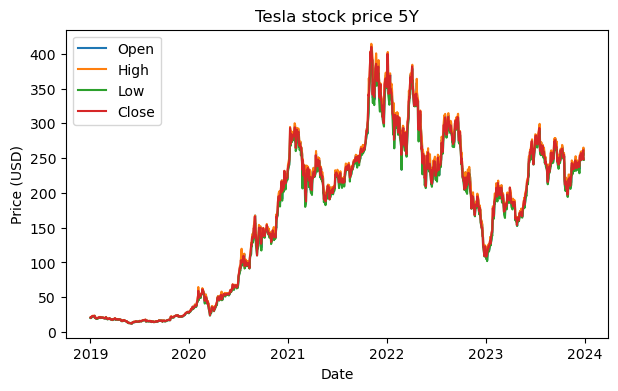

In [9]:
plt.figure(figsize = (7,4))
plt.title('Tesla stock price 5Y')
plt.plot(df.Open, label="Open")
plt.plot(df.High, label="High")
plt.plot(df.Low, label="Low")
plt.plot(df.Close, label="Close")
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.savefig('03_LSTM_OHLC.pdf', format='pdf', bbox_inches='tight')
plt.show()

> **TODO:** Plot OHLC. you may want to install libraries below:
> - `pip install https://github.com/matplotlib/mpl_finance/archive/master.zip`
> - `pip install mplfinance`
> - `pip install finplot`

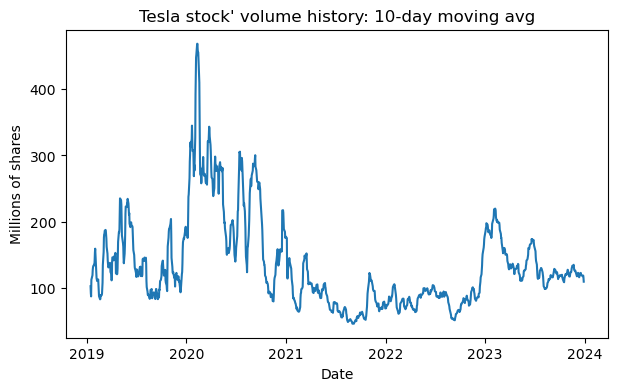

In [11]:
plt.figure(figsize = (7,4))
plt.title("Tesla stock' volume history: 10-day moving avg")
plt.plot(df.Volume.rolling(10).mean()/1e6)
plt.ylabel('Millions of shares')
plt.xlabel('Date')
plt.show()

## 3️⃣ Data Preparation
### Split training & testing data (70%-30%)

In [13]:
# Extract 'Close' price for modeling
data_target = df[['Close']].values
training_data_len = int(len(data_target) * 0.7)  # Hyperparameter: 70% for training

train_data = data_target[:training_data_len]
test_data = data_target[training_data_len:]

print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

Training data length: 880
Testing data length: 378


### Dataset normalization

In [15]:
# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(train_data)

# Apply same scaling to test data
scale_factor = scaler.scale_
data_testing_array = test_data * scale_factor

### Construct sequential training and testing data

In [17]:
# Hyperparameter: Lookback period
lookback = 100

# Training sequences
x_train, y_train = [], []
for i in range(lookback, data_training_array.shape[0]):
    x_train.append(data_training_array[i - lookback:i])
    y_train.append(data_training_array[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Testing sequences
x_test, y_test = [], []
for i in range(lookback, data_testing_array.shape[0]):
    x_test.append(data_testing_array[i - lookback:i])
    y_test.append(data_testing_array[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

print(f"Training x, y shape: {x_train.shape}, {y_train.shape}")
print(f"Testing x, y shape: {x_test.shape}, {y_test.shape}")

Training x, y shape: (780, 100, 1), (780,)
Testing x, y shape: (278, 100, 1), (278,)


## 4️⃣ Build LSTM Model

In [19]:
# Initialize sequential model
model = Sequential()

# LSTM layers with dropout (hyperparameters: units, dropout rates)
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [20]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

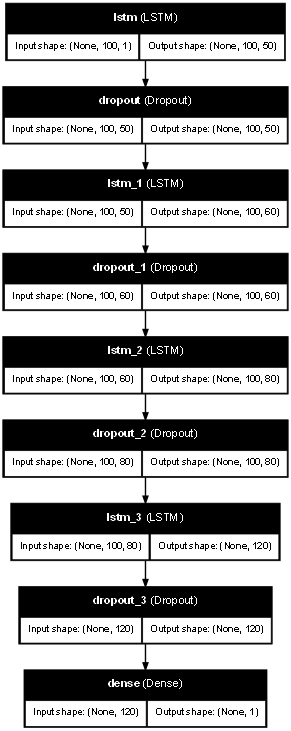

In [21]:
# Visualize model architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=50)

> **TODO:** Experiment with different LSTM units and dropout rates.

## 5️⃣ Train the model

In [24]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])

In [25]:
%%time

# Train model with validation split (TODO: Use validation_split=0.3 and shuffle=True)
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=10,  # Hyperparameter
    validation_split=0.3,
    shuffle=True,
    callbacks=[EarlyStopping(patience=5)]
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 359ms/step - MAE: 0.1841 - loss: 0.0620 - val_MAE: 0.1587 - val_loss: 0.0345
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - MAE: 0.0691 - loss: 0.0092 - val_MAE: 0.1213 - val_loss: 0.0223
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - MAE: 0.0531 - loss: 0.0062 - val_MAE: 0.0742 - val_loss: 0.0104
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - MAE: 0.0653 - loss: 0.0096 - val_MAE: 0.1012 - val_loss: 0.0171
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 328ms/step - MAE: 0.0552 - loss: 0.0063 - val_MAE: 0.1056 - val_loss: 0.0180
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - MAE: 0.0476 - loss: 0.0055 - val_MAE: 0.1039 - val_loss: 0.0176
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - MAE: 0.0508 - loss: 0.0047 - val_MAE: 0.0898 - val_loss: 0.0143
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step - MAE: 0.0478 - loss: 0.0047 - val_MAE: 0.0771 - val_loss: 0.0116
CPU times: total: 5min 52s
Wall time: 2min 52s


In [26]:
# Evaluate model on test data
scores = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {scores[0]:.4f}")
print(f"Test MAE: {scores[1]:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - MAE: 0.0653 - loss: 0.0063
Test loss: 0.0046
Test MAE: 0.0556


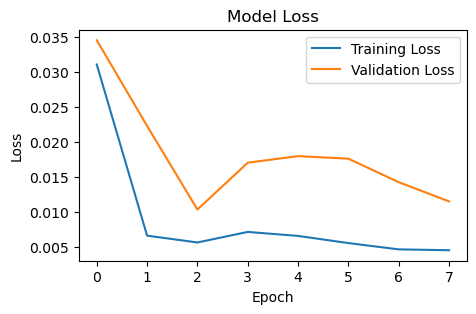

In [27]:
# Plot loss
plt.figure(figsize=(5, 3))
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.savefig('03_LSTM_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

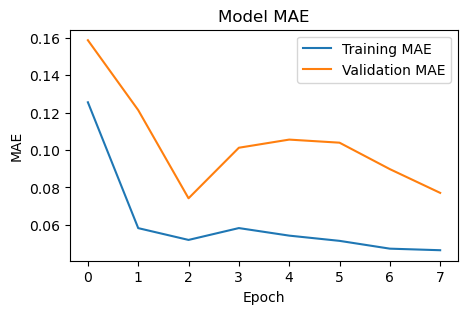

In [28]:
# Plot MAE
plt.figure(figsize=(5, 3))
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(history.history['MAE'], label='Training MAE')
plt.plot(history.history['val_MAE'], label='Validation MAE')
plt.legend()
plt.savefig('03_LSTM_mae.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 6️⃣ Make predictions

### Predict on Test Data

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step


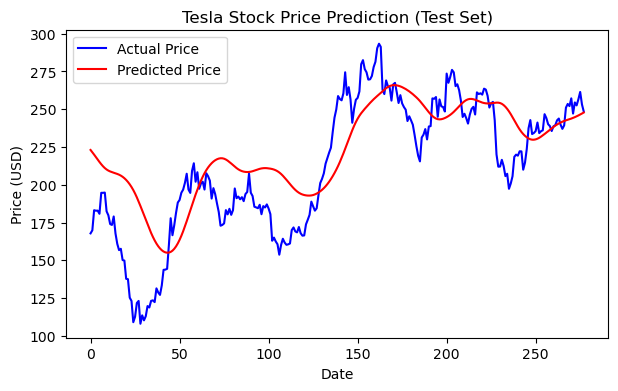

Mean Absolute Error on test set: 23.0847


In [31]:
# Predict on test data
y_pred = model.predict(x_test)
price_pred = scaler.inverse_transform(y_pred)

# Plot test predictions vs actual
plt.figure(figsize=(7, 4))
plt.title('Tesla Stock Price Prediction (Test Set)')
plt.plot(y_test / scale_factor, 'b', label="Actual Price")
plt.plot(price_pred, 'r', label="Predicted Price")
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.savefig('03_LSTM_testset.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Calculate MAE
mae = mean_absolute_error(y_test / scale_factor, price_pred)
print(f"Mean Absolute Error on test set: {mae:.4f}")

### Predict on Validation Data (`TODO`)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


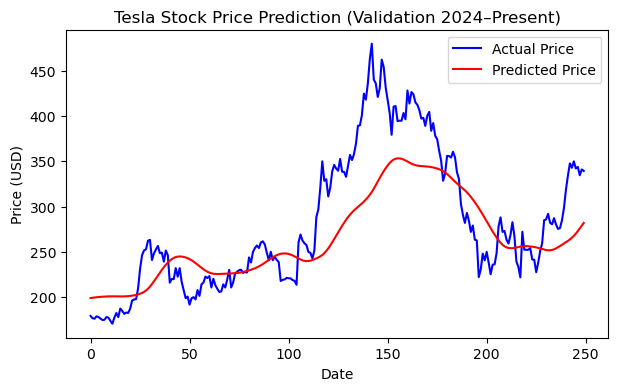

Mean Absolute Error on validation set: 36.1784


In [33]:
# Prepare validation data
val_target = val_df[['Close']].values
val_data_array = val_target * scale_factor

# Create sequences for validation
x_val, y_val = [], []
for i in range(lookback, val_data_array.shape[0]):
    x_val.append(val_data_array[i - lookback:i])
    y_val.append(val_data_array[i, 0])
x_val, y_val = np.array(x_val), np.array(y_val)

# Predict on validation data
y_val_pred = model.predict(x_val)
price_val_pred = scaler.inverse_transform(y_val_pred)

# Plot validation predictions vs actual
plt.figure(figsize=(7, 4))
plt.title('Tesla Stock Price Prediction (Validation 2024–Present)')
plt.plot(y_val / scale_factor, 'b', label="Actual Price")
plt.plot(price_val_pred, 'r', label="Predicted Price")
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.savefig('03_LSTM_valid.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Calculate MAE for validation
mae_val = mean_absolute_error(y_val / scale_factor, price_val_pred)
print(f"Mean Absolute Error on validation set: {mae_val:.4f}")

### Visualize Full Prediction Timeline

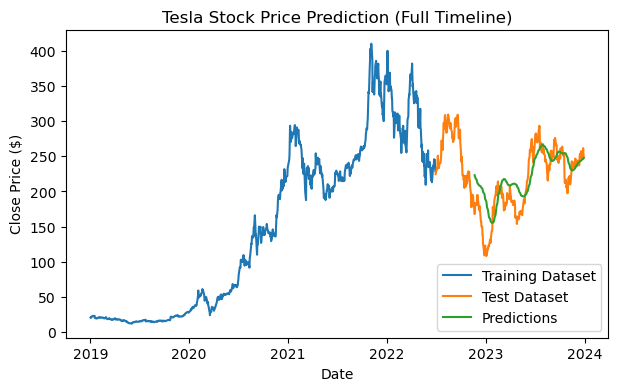

In [35]:
# Prepare data for full timeline plot
train = df[['Close']][:training_data_len]
test = df[['Close']][training_data_len:]
pred = df[['Close']][training_data_len + lookback:].copy()
pred['Predictions'] = price_pred

# Plot full timeline
plt.figure(figsize=(7, 4))
plt.title('Tesla Stock Price Prediction (Full Timeline)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.plot(train, label='Training Dataset')
plt.plot(test, label='Test Dataset')
plt.plot(pred['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.savefig('03_LSTM_preds.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 7️⃣ Save the Model

In [37]:
# model.save('keras_model_tsla_2019_2024.h5')